# ltest

Load test axisymmetric or strip shallow foundation in [Plaxis 2D](https://www.bentley.com/software/plaxis-2d/#:~:text=PLAXIS%20is%20a%20computer%20application,code%20of%20the%20software%20application.).

## License

Distributed under the MIT License. See LICENSE.txt for more information.

## Acknowledgments

`ltest` is developed by Pablo Barbieri. Professor Timothy Newson provides the technical overview of the project.

This work was supported by the Natural Sciences and Engineering Research Council of Canada (Grant #: RGPIN-2020-06713).

### Contact

You can reach Pablo Barbieri at pbarbie2@uwo.ca.

## Change log

- 2023-10-31 -- 0.0.1:
    - First release.
- 2023-11-05 -- 0.0.2: 
    - Added model_type to README. 
    - Complete docstrings.
    - Fixed compression positive, pull-out positive flags in test plot.
    - 5-node elements supported.
    - Model size set at creation in Plaxis.

## Getting started

### Requirements

``ltest`` can either be used within the Plaxis [remote scripting Python wrap](https://communities.bentley.com/products/geotech-analysis/w/wiki/46005/using-plaxis-remote-scripting-with-the-python-wrapper) or in a regular Python environment. ``ltest`` requires [pandas](https://pandas.pydata.org/docs/index.html) which is not included by default in Plaxis Python environment. To install it, or any other package, follow the instructions listed on [Plaxis site](https://communities.bentley.com/products/geotech-analysis/w/wiki/51822/how-to-install-additional-python-modules-in-plaxis).

To use ``ltest`` in a custom Python environment, the ``plxscripting`` package must be installed in that environment along all other required packages. ``plxscripting`` cannot be installed using conda or pip. Instead, it must be installed following the [these instructions](https://communities.bentley.com/products/geotech-analysis/w/wiki/51822/how-to-install-additional-python-modules-in-plaxis).

<div class="alert alert-info">
  
Beware that ``plxscripting`` requires Python 3.7. **It will crash with later versions.**

</div>

### Installation

Clone the repo:

`git clone https://github.com/p-barb/ltest`

## Usage

### Plaxis connection

Along with ``ltest`` you will need to import ``plxscripting`` and connect with Plaxis following [these instructions](https://communities.bentley.com/products/geotech-analysis/w/wiki/46005/using-plaxis-remote-scripting-with-the-python-wrapper).

In [1]:
from plxscripting.easy import *
import ltest 

password = "nicFgr^TtsFm~h~M"
localhostport_input = 10000 
localhostport_output = 10001
s_i, g_i = new_server('localhost', localhostport_input, password=password) 
s_o, g_o = new_server('localhost', localhostport_output, password=password)

### Create foundation model

<div class="alert alert-info">
  
The model units are **kN** and **m** by default.

</div>

The geometry of the foundation is given by:

In [2]:
d = 1.2 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

Materials are defined by dictionaries containing the properties required in each case by Plaxis. Liner-Elastic, Mohr-Coulomb and Hardening Soil (HS) soil materials are supported. A Mohr-Coulomb material is used for the soil:

In [3]:
# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

The foundation itself is modeled by plate elements. The `concrete` methods generates the dictionary with the plate material properties from the desired compressive strength, unit weight and plate thickness.

In [4]:
# Plate material for a f'c=30MPa concrete slab with a 40cm thickness and 24kN/m3 unit weight
column = ltest.concrete(30, 24, b1)
# Plate material for a f'c=30MPa concrete slab with a 60cm thickness and 24kN/m3 unit weight
footing = ltest.concrete(30, 24, d1)

Create a foundation model using plate elements for the column and footing:

In [5]:
model = ltest.PlateModel(s_i, g_i, g_o, b, d, soil, footing, column)

The resulting model geometry can be inspected visually:

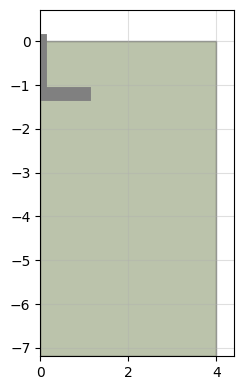

In [6]:
model.plot()

### Load test

A load test is conducted using the ``load_test`` method. A test consist in consecutive load levels being applied to the foundation. Negative loads imply compression, while positive pull-out. Each load level is a phase where the load is set to the provided value.

In [7]:
testid = 'test A'
load = [-60, 0, -60] #kN
model.load_test(testid, load)

Calculation results are stored in a dataframe:

In [8]:
model._results

,test,phase,previous,plx id,previous plx id,location,step,load start,load end,load,sumMstage,fy,qy,uy,ratchetting
0,None,construction,None,Phase_1,None,top,1.0,0,0,0,0.500000,0.000000,0.0,2.102337e-14,False
1,None,construction,None,Phase_1,None,top,2.0,0,0,0,1.000000,0.000000,0.0,4.205183e-14,False
2,None,construction,None,Phase_1,None,0,1.0,0,0,0,0.500000,0.000000,0.0,2.102337e-14,False
3,None,construction,None,Phase_1,None,0,2.0,0,0,0,1.000000,0.000000,0.0,4.205183e-14,False
4,None,construction,None,Phase_1,None,0.25,1.0,0,0,0,0.500000,0.000000,0.0,2.101860e-14,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,test A,test A_stage_2,test A_stage_1,Phase_4,Phase_3,1,57.0,0,-60,-60,0.933058,-55.983485,0.0,-5.571149e-03,False
1580,test A,test A_stage_2,test A_stage_1,Phase_4,Phase_3,1,58.0,0,-60,-60,0.950746,-57.044785,0.0,-5.652880e-03,False
1581,test A,test A_stage_2,test A_stage_1,Phase_4,Phase_3,1,59.0,0,-60,-60,0.968435,-58.106081,0.0,-5.735502e-03,False
1582,test A,test A_stage_2,test A_stage_1,Phase_4,Phase_3,1,60.0,0,-60,-60,0.986123,-59.167382,0.0,-5.819989e-03,False


By default 6 points are selected surveyed. The load application point at the surface, and points located at the foundation level at a distance of 0, 0.25, 0.5, 0.75 and 1 times b/2. The load test results can be inspected using the ``plot_test`` function.

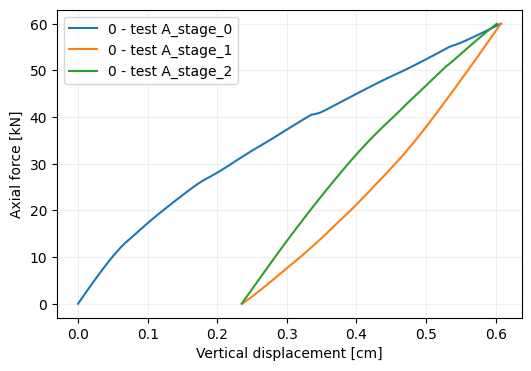

In [9]:
model.plot_test('test A', location=0, legend=True)

Multiple load tests can be performed in the same model.Each load test will start from the construction phase. **

### Failure test

The `failure_test` method applies tests the foundation until the model does not converge. A first trial is done using the the `start_load`. If lack of convergence is not achieved, the load is incremented as `load = load_factor * load + load_increment`. The fourth argument controls whether a '`compression'` or `'pull out'` test is performed.

In [10]:
testid = 'compression'
model.failure_test(testid, 'compression')

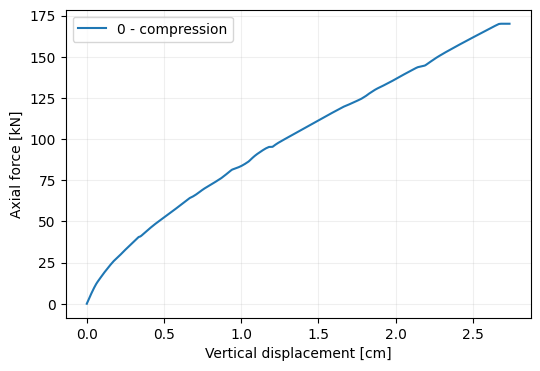

In [11]:
model.plot_test('compression', location=0, legend=True)

In [12]:
testid = 'pull out'
model.failure_test(testid, 'pull out', start_load=60, load_factor=3)

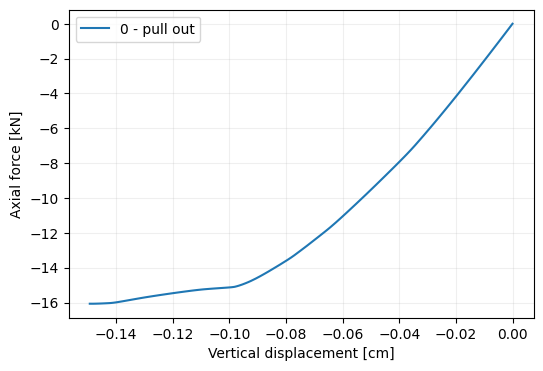

In [13]:
model.plot_test('pull out', location=0, legend=True)

Test results are stored in the results dataframe and can be plotted using the `plot_test` method.

### General model settings

The `model_type` argument can be set to `'axisymmetry'` (default) or `'planestrain'`. Also, the title and comments of the model in Plaxis can be set with the `title` and `comments` arguments.

In [14]:
model = ltest.PlateModel(s_i, g_i, g_o, b, d, soil, footing, column,
                        model_type='planestrain', title='Plain strain',
                        comments='This is a plain strain model example.')

### Element type

The `element_type` argument controls the type of elements used in the model. It can be set to `'6-Noded'` or `'15-Noded'`. By default 15-noded elements are used.

In [16]:
model = ltest.PlateModel(s_i, g_i, g_o, b, d, soil, footing, column,
                        element_type='6-Noded')

### Save/Load

Saving a load test wipes out the Plaxis objects stored in it. This prevents the load test object from further communicating with Plaxis, so no additional can be performed. The information regarding the model geometry, material properties and test results is preserved.

In [17]:
model.save('exmaple_model.mdl')

WARNIGN: Saving the load test to memory whipes out the Plaxis objects. Test results and input parameters will still be avaiable, but no further interaction with Plaxis will be possible. The model can be restored with the <regen> method, but load tests will have to be recalculated to access the results whitin Plaxis.

 Do you whish to proceed: [Y/n] y


The `regen` method regenerates the Plaxis model from a saved model so it can be used to calculate new tests. It can also recalculate the saved tests by setting the argument `test` to `True`. 

In [18]:
model = ltest.load('exmaple_model.mdl')
model.regen(s_i, g_i, g_o)

### Preliminary model check

Waiting for Plaxis to build and run the initial phases can be time consuming only to check that the model has the correct geometry. The `build` attribute controls whether the Plaxis model gets build. By setting it to `False` the geometry can be inspecting with `plot()`.

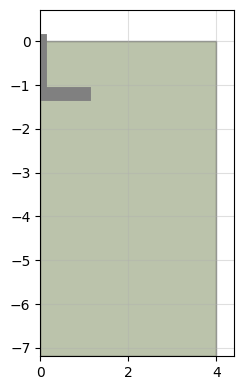

In [19]:
model = ltest.PlateModel(s_i, g_i, g_o, b, d, soil, footing, column, build=False)
model.plot()

The `build()` method creates the model in Plaxis so it can be used. 

In [20]:
model.build()

## Foundation geometry

### Solid foundations

Foundations can be modeled using a solid area instead of plates. A soil material must be provided for the concrete.

In [21]:
# Geometry
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

model = ltest.SolidModel(s_i, g_i, g_o, b, d, b1, d1, soil, concrete)

The resulting model is:

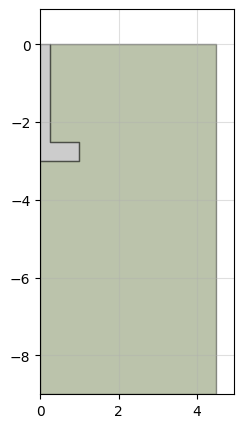

In [22]:
model.plot()

### Surface foundations

A surface foundation is created by setting the depth to 0. If the foundation is modeled by plate elements, no material need to be provided for the column:

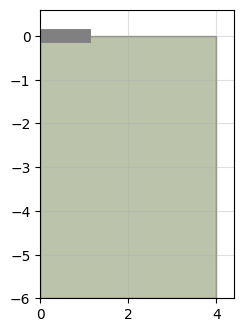

In [23]:
d = 0 # Foundation depth
b = 2 # Foundation width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# Create with f'c=30MPa concrete slab with a 60cm thickness and 24kN/m3 unit weight
footing = ltest.concrete(30, 24, d1)
column = None

# Create model
model = ltest.PlateModel(s_i, g_i, g_o, b, d, soil, footing, column)
model.plot()

If the foundation is modeled as a solid, the column width is still required as the width of the applied uniform load on top of the foundation.

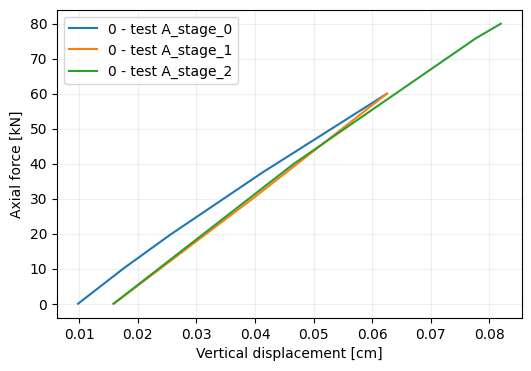

In [24]:
# Geometry
d = 0 # Foundation depth
b = 2 # Foundation width
b1 = 0.6 # Load width
d1 = 0.3 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

model = ltest.SolidModel(s_i, g_i, g_o, b, d, b1, d1, soil, concrete)

testid = 'test A'
load = [-60, 0, -80] #kN
model.load_test(testid, load)
model.plot_test('test A', location=0, legend=True)

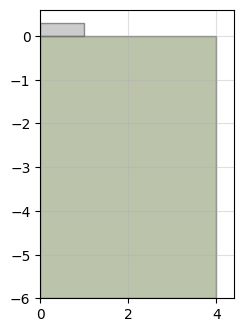

In [25]:
model.plot()

The foundation can be partially embedded:

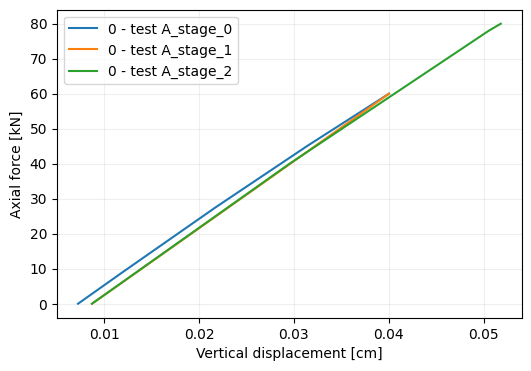

In [26]:
# Geometry
d = 0.3 # Foundation depth
b = 2 # Foundation width
b1 = 0.6 # Load width
d1 = 0.5 # Foundation width

model = ltest.SolidModel(s_i, g_i, g_o, b, d, b1, d1, soil, concrete)
testid = 'test A'
load = [-60, 0, -80] #kN
model.load_test(testid, load)
model.plot_test('test A', location=0, legend=True)

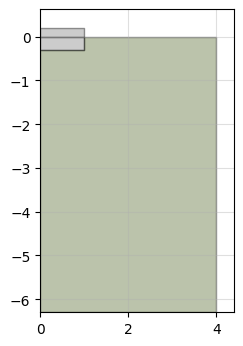

In [27]:
model.plot()

### Stratification

Multiple soil layers are defined by providing a soil material for each layer and specify each layer thickness with the `dstrata` parameter. If the model height exceeds the combined height of the individual layers, the bottom layer is extended.

In [28]:
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb top soil material
top_layer = {}
top_layer['SoilModel'] = 'mohr-coulomb'
top_layer["DrainageType"] = 0
top_layer['gammaSat'] = 20 # kN/m3
top_layer['gammaUnsat'] = 17 # kN/m3
top_layer['e0'] = 0.2
top_layer['Eref'] = 4e4 # kN
top_layer['nu'] = 0.2
top_layer['cref'] = 0 # kPa
top_layer['phi'] = 30 # deg
top_layer['psi'] = 0 # deg

# Mohr-Coulomb second soil material
mid_layer = {}
mid_layer['SoilModel'] = 'mohr-coulomb'
mid_layer["DrainageType"] = 0
mid_layer['gammaSat'] = 20 # kN/m3
mid_layer['gammaUnsat'] = 17 # kN/m3
mid_layer['e0'] = 0.2
mid_layer['Eref'] = 4e4 # kN
mid_layer['nu'] = 0.2
mid_layer['cref'] = 0 # kPa
mid_layer['phi'] = 32 # deg
mid_layer['psi'] = 0 # deg

# Mohr-Coulomb second soil material
bottom_layer = {}
bottom_layer['SoilModel'] = 'mohr-coulomb'
bottom_layer["DrainageType"] = 0
bottom_layer['gammaSat'] = 20 # kN/m3
bottom_layer['gammaUnsat'] = 17 # kN/m3
bottom_layer['e0'] = 0.2
bottom_layer['Eref'] = 4e4 # kN
bottom_layer['nu'] = 0.2
bottom_layer['cref'] = 0 # kPa
bottom_layer['phi'] = 39 # deg
bottom_layer['psi'] = 0 # deg

# Plate material for a f'c=30MPa concrete slab with a 40cm thickness and 24kN/m3 unit weight
column = ltest.concrete(30, 24, b1)
# Plate material for a f'c=30MPa concrete slab with a 60cm thickness and 24kN/m3 unit weight
footing = ltest.concrete(30, 24, d1)

In [29]:
model = ltest.PlateModel(s_i, g_i, g_o, b, d,
                         [top_layer, mid_layer, bottom_layer], footing, column,
                         dstrata=[1, 2, 3])

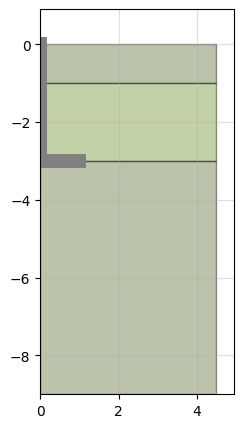

In [30]:
model.plot()

### Fill

The fill material used in buried foundations is included in the model by provided a soil material in the `fill` argument and the excavation slope (in degrees) in the `fill_angle` argument. The model includes the initial phase with only the original stratigraphy, an excavation phase where the soil material is removed, and a construction phase where the foundation and the fill are activated.

In [31]:
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb top soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 30 # deg
soil['psi'] = 0 # deg

# Mohr-Coulomb second soil material
fill = {}
fill['SoilModel'] = 'mohr-coulomb'
fill["DrainageType"] = 0
fill['gammaSat'] = 20 # kN/m3
fill['gammaUnsat'] = 17 # kN/m3
fill['e0'] = 0.2
fill['Eref'] = 4e4 # kN
fill['nu'] = 0.2
fill['cref'] = 0 # kPa
fill['phi'] = 32 # deg
fill['psi'] = 0 # deg


# Plate material for a f'c=30MPa concrete slab with a 40cm thickness and 24kN/m3 unit weight
column = ltest.concrete(30, 24, b1)
# Plate material for a f'c=30MPa concrete slab with a 60cm thickness and 24kN/m3 unit weight
footing = ltest.concrete(30, 24, d1)

model = ltest.PlateModel(s_i, g_i, g_o, b, d, soil, 
                         column, footing, fill=fill,
                         fill_angle=25)

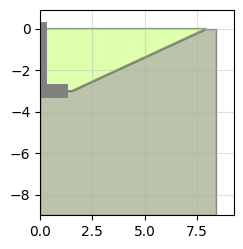

In [32]:
model.plot()

The `nfill` parameter generates multiple fill layers of equal thickness. A list of soil materials for each layer must be provided, from top to bottom. 

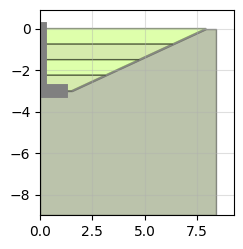

In [33]:
model = ltest.PlateModel(s_i, g_i, g_o, b, d, soil, footing, column,
                         nfill=4, fill=[fill,fill,fill,fill],
                         fill_angle=25)
model.plot()

The `dfill` parameter generates fill layers of the requested thickness. If the cumulative thickness of the fill layers is below the foundation depth, and additional layer is added.

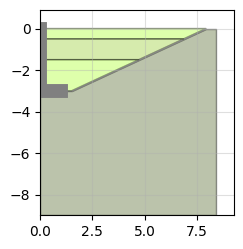

In [34]:
model = ltest.PlateModel(s_i, g_i, g_o, b, d, soil,
                         footing, column,
                         dfill=[0.5, 1], fill=[fill,fill,fill],
                         fill_angle=25)
model.plot()

The `bfill` parameter controls the distance between the edge of the foundation and the start of the fill slope.

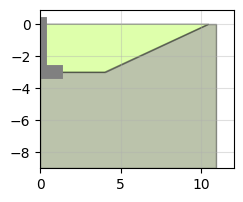

In [35]:
model = ltest.PlateModel(s_i, g_i, g_o, b, d,
                         soil,  footing, column,
                         fill=[fill], fill_angle=25, bfill=3)
model.plot()

### Water table

The `wt` parameter specifies the global water table of the model, which is applied to all stages.

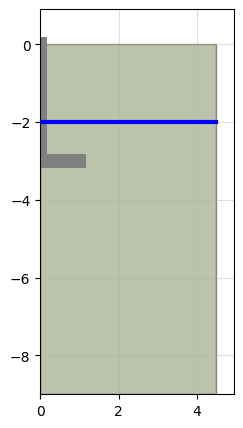

In [36]:
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# Plate material for a f'c=30MPa concrete slab with a 40cm thickness and 24kN/m3 unit weight
column = ltest.concrete(30, 24, b1)
# Plate material for a f'c=30MPa concrete slab with a 60cm thickness and 24kN/m3 unit weight
footing = ltest.concrete(30, 24, d1)

# initialize model
model = ltest.PlateModel(s_i, g_i, g_o, b, d, soil, footing, column, wt=2)

# plot
model.plot()

### Interfaces

By default an interface is included between the column and the soil. Additional interfaces can be included in the top and bottom of the footing and, for the solid foundation, on its side as well. Interfaces are controlled through the `interface` argument. If set to `True` all interfaces will be activated. Likewise, if set to `False` all interfaces are deactivated. Individual activations are handled via a dictionary with keys `'column'`, `'top'`, `'bottom'` and `'lateral'`.

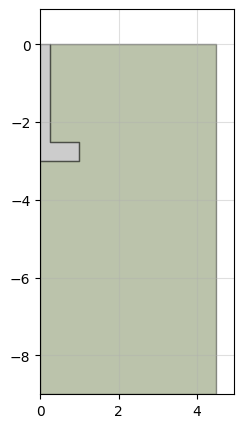

In [37]:
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# Plate material for a f'c=30MPa concrete slab with a 40cm thickness and 24kN/m3 unit weight
# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# initialize model
model = ltest.SolidModel(s_i, g_i, g_o, b, d, b1, d1,
                         soil, concrete, interface={'lateral':True, 'bottom':True})

# plot
model.plot()

### Model size

The `model_width` and  `model_depth` parameters control the extent of the model.

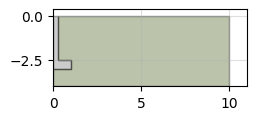

In [38]:
d = 3 # Foundation depth
b = 2 # Foundation width
b1 = 0.5 # Foundation column width
d1 = 0.5 # Foundation width

# Mohr-Coulomb soil material
soil = {}
soil['SoilModel'] = 'mohr-coulomb'
soil["DrainageType"] = 0
soil['gammaSat'] = 20 # kN/m3
soil['gammaUnsat'] = 17 # kN/m3
soil['e0'] = 0.2
soil['Eref'] = 4e4 # kN
soil['nu'] = 0.2
soil['cref'] = 0 # kPa
soil['phi'] = 35 # deg
soil['psi'] = 0 # deg

# Plate material for a f'c=30MPa concrete slab with a 40cm thickness and 24kN/m3 unit weight
# elastic material for concrete
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 730e3  # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 20
concrete['gammaUnsat'] = 17

# initialize model
model = ltest.SolidModel(s_i, g_i, g_o, b, d, b1, d1, soil, concrete,
                         model_width=10, model_depth=4)

# plot
model.plot()

## Materials

### Soil materials

#### Linear elastic

Linear elastic soil materials are specified by a dictionary whit the following fields:

In [39]:
material = {}
material['SoilModel'] = 'elastic'
material["DrainageType"] = 0
material['Eref'] = 728e3 # kPa
material['nu'] = 0.4 #
material['gammaSat'] = 17
material['gammaUnsat'] = 20

There are optional parameters that, if not provided, the default value calculated by Plaxis is assigned:

In [40]:
material['Rinter'] = 0.5  # interface strength, default value 1
material['kx'] = 0.02 # [m/day] Permeability in the horizontal direction, default value 0
material['ky'] = 0.04 # [m/day] Permeability in the vertical direction, default value 0

#### Mohr-Coulomb

Mohr-Coulomb soil materials are specified by a dictionary whit the following fields:

In [41]:
# Mohr-Coulomb soil material
material = {}
material['SoilModel'] = 'mohr-coulomb'
material["DrainageType"] = 0
material['gammaSat'] = 20 # kN/m3
material['gammaUnsat'] = 17 # kN/m3
material['e0'] = 0.2
material['Eref'] = 4e4 # kN
material['nu'] = 0.2
material['cref'] = 0 # kPa
material['phi'] = 35 # deg
material['psi'] = 0 # deg

There are optional parameters that, if not provided, the default value calculated by Plaxis is assigned:

In [42]:
soil['Rinter'] = 0.5 # interface strength, default value 1
soil['K0nc'] = 0.6 # default value sin(45 - phi / 2)
soil['kx'] = 0.02 # [m/day] Permeability in the horizontal direction, default value 0
soil['ky'] = 0.04 # [m/day] Permeability in the vertical direction, default value 0

#### Hardening soil

Hardening soil materials are specified by a dictionary whit the following fields:

In [43]:
material = {}
material['SoilModel'] = 'hardening soil'
material["DrainageType"] = 0
material['gammaSat'] = 17
material['gammaUnsat'] = 20
material['e0'] = 0.2
material['E50ref'] = 4e4
material['Eoedref'] = 4e4
material['Euref'] = 1.2e5
material['powerm'] = 0.5
material['c'] = 0
material['phi'] = 32
material['psi'] = 2
material['nu'] = 0.2

There are optional parameters that, if not provided, the default value calculated by Plaxis is assigned:

In [44]:
material['Rinter'] = 0.5 # interface strength, default value 1
material['K0nc'] = 0.6 # default value sin(45 - phi / 2)
material['kx'] = 0.02 # [m/day] Permeability in the horizontal direction, default value 0
material['ky'] = 0.04 # [m/day] Permeability in the vertical direction, default value 0

### Plate materials

Plate materials are specified by a dictionary whit the following fields:

In [45]:
plate_material = {}
plate_material['nu'] = 0.4
plate_material['EA'] = 7.73e6 # KPa m
plate_material['EI'] = 0.3**2 / 12 * 7.73e6 # KPa m
plate_material['d'] = 0.3 # m
plate_material['Gref'] = 7.73e6 / (2 * 0.3 * (1 + 0.4)) # KPa

Plates material are specified per m of cross-section width. Therefore, the stiffness parameters must comply with the following relations. The equivalent thickness `d` is related to the axial and flexural stiffness by:

$$d=\sqrt{12 \frac{EI}{EA}}$$

The reference shear modulus:

$$G_{ref} = \frac{EA}{2 \ d \ \left(1 + \nu \right)}$$

An alternative way to define a plate material is using the `concrete function`, where the properties of the plate are computed form the compressive strength of concrete as:

$$E \left[kPa\right] = 4700 \ \sqrt{f'_c} \ 10^3$$

$$EA = E \ d \ 1m$$

$$EI = E \ \frac{d^3 \ 1m}{12}$$

$$w = \gamma \ d \ 1m $$

The default value for the Poisson modulus can be modified when calling the function:

In [46]:
fc = 30 # MPa
gamma = 24 #kN/m3
d = 0.4
ltest.concrete(fc, gamma, d, poisson=0.3)

{'fc': 30,
 'E': 25742960.202742808,
 'nu': 0.3,
 'EA': 10297184.081097124,
 'EI': 137295.78774796167,
 'd': 0.4,
 'Gref': 9901138.539516464,
 'gamma': 24,
 'w': 9.600000000000001}